In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from hydracv.midline import find_midline_midpoints, find_midline_midpoints_corrected
from hydracv.fluorescence import trace_fluo
import hydracv.utils.utils as utils

In [2]:
BISECTION_DATA_HOME = "/Users/katyabrooun/Google Drive/Shared drives/hydra/data-analysis/Bisection_Full/"
VIDEO_NAME = "71420_ngcamp_hy5_peduncle72hr" # TO MODIFY
FPS = 5 # frames per second in original video (used to convert frames to seconds for x axes on plots)
BODY_PART = '/Peduncle/' # TO MODIFY
EXP_NAME = 'GCaMP6_Bisection_Exp5'# TO MODIFY
SAVE_DIR = '/Users/katyabrooun/Fairhall_Lab/hydra/bisection-data-analysis/exp5' + BODY_PART # TO MODIFY

In [3]:
# for saving off data
FILE_FLUO = SAVE_DIR + 'total_fluo_' + VIDEO_NAME + '.csv'
FILE_MIDPOINTS = SAVE_DIR + "midpoints_"+ VIDEO_NAME +".csv"
FILE_LENGTH = SAVE_DIR + "lengths_" + VIDEO_NAME + ".csv"

## Midline and length

Requirements: 
- per-frame contours
- tracked data (results from DeepLabCut)

In [4]:
FILE_CONTOUR_1 = BISECTION_DATA_HOME + 'Icy_Contours/' + EXP_NAME + BODY_PART + VIDEO_NAME +  "_ROIs.xml"
# FILE_CONTOUR_2 = BISECTION_DATA_HOME + 'Icy_Contours/' + EXP_NAME + BODY_PART + VIDEO_NAME +  "_ROIs_pt2.xml"
FILE_MARKER = BISECTION_DATA_HOME + 'DLC_Data/' + EXP_NAME + BODY_PART + "72hr/" \
"71420_ngcamp_hy5_peduncle72hrDeepCut_resnet50_Hydra_Bissect_EXP5_peducnle_72hrDec29shuffle1_15000.csv" # TO MODIFY

In [5]:
# Original find midline code
midpoints_orig = find_midline_midpoints.find_midline(file_contour=[FILE_CONTOUR_1],
                                                     file_marker=FILE_MARKER,
                                                     nseg=40,
                                                     play=False)

Contour loaded, the size is: 7307


  1%|          | 78/7307 [00:00<00:09, 779.28it/s]

Markers loaded, the size is: 7307
Number of missed contours is: 0


100%|██████████| 7307/7307 [00:08<00:00, 812.34it/s] 


In [6]:
# Save the original midpoints
df = pd.DataFrame(midpoints_orig)
df.to_csv(FILE_MIDPOINTS, index=False)

In [7]:
midpoints_orig_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS)
midlens = find_midline_midpoints_corrected.extract_lengths(midpoints_orig_data, normalize=False)

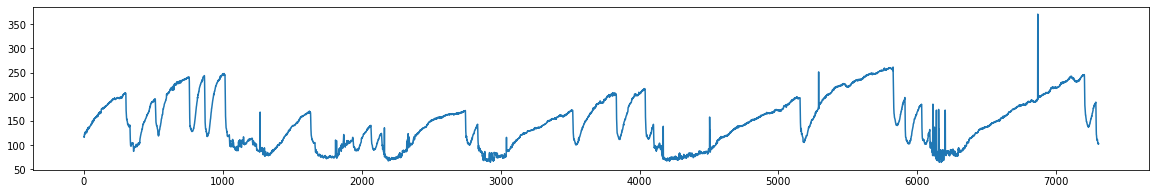

In [8]:
plt.figure(figsize=(20,3))
plt.plot(midlens)
plt.show()

In [9]:
# Save the lengths (per frame)
df = pd.DataFrame(midlens)
df.to_csv(FILE_LENGTH, index=False)

## Fluorescence

Requirements: 
- video

Optional:
- single ROI specifying which portion of video frames to compute fluorescence over (useful if there are external objects in video)

In [10]:
FILE_VIDEO = BISECTION_DATA_HOME + "Original_Videos/" + EXP_NAME + BODY_PART + VIDEO_NAME + ".avi"
FILE_FLUO_ROI = BISECTION_DATA_HOME + 'Icy_Contours/' + EXP_NAME + BODY_PART + VIDEO_NAME +  "_max_intensity_ROI.xml"

In [11]:
# Optional (use if slide appears in video partway through)
ROI = []
ROI = find_midline_midpoints.load_contour([FILE_FLUO_ROI]) # TO UPDATE

In [12]:
# Calculate fluorescence intensity for each video frame
fluo = trace_fluo.trace(FILE_VIDEO, display=False, ROI=ROI)

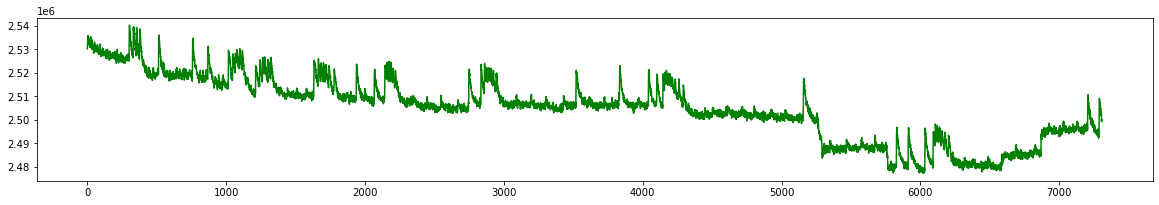

In [13]:
# Plot fluorescence
fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
plt.plot(fluo, 'g')
plt.show()

In [14]:
# Save the results
df = pd.DataFrame(fluo)
df.to_csv(FILE_FLUO, index=False)

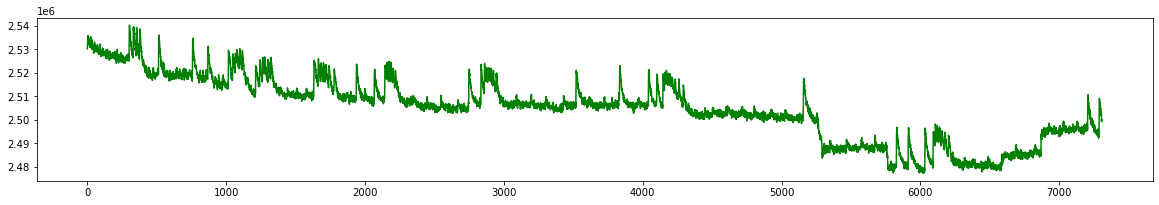

In [15]:
fluo = pd.read_csv(FILE_FLUO)
# Plot fluorescence
fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
plt.plot(fluo, 'g')
plt.show()

## Compare midline length and fluorescence

In [16]:
midlens = pd.read_csv(FILE_LENGTH)

fluo = pd.read_csv(FILE_FLUO)

minlen = min(len(midlens), len(fluo))

In [17]:
# using this to work around nan values in midlens data
def norm_to_zero_one_df(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

def norm_to_zero_one_np(arr):
    return (arr - np.min(arr)) * 1.0 / (np.max(arr) - np.min(arr))

In [18]:
midlens_norm = norm_to_zero_one_df(midlens)[:minlen]
fluo_norm = norm_to_zero_one_np(fluo)[:minlen]

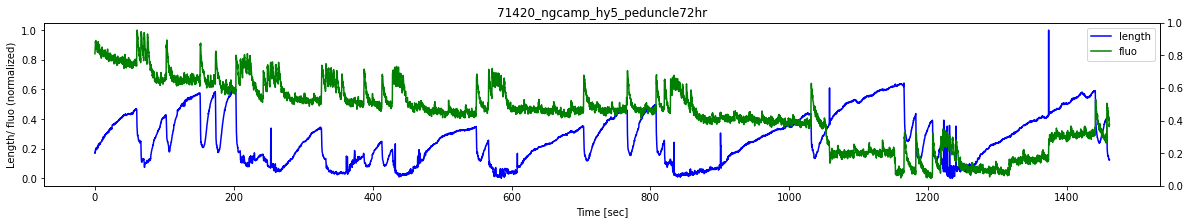

In [19]:
# Plot overlayed length and fluorescence

timex = np.arange(0, minlen/FPS, 1/FPS)

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
ax_ = ax.twinx()
lns1 = ax.plot(timex, midlens_norm, 'b', label='length')
lns2 = ax.plot(timex, fluo_norm, 'g', label='fluo')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')
ax.set(xlabel='Time [sec]', ylabel='Length/ fluo (normalized)', title=VIDEO_NAME)

# save plot (without highlighting)
plt.savefig(SAVE_DIR + VIDEO_NAME + "_plot.jpg")

In [20]:
# highlight portion of graph to display alongside movie clip
# ax.axvspan(100, 250, color='yellow', alpha=0.5)
# fig